In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
df_train_est_A = pd.read_csv('train_est_B.csv')
df_train_obs_A = pd.read_csv('train_obs_B.csv')
df_test_A = pd.read_csv('X_test_B.csv')
df_train_est_A = df_train_est_A.rename(columns={'Unnamed: 0': 'date_forecast'})

df_train_obs_A = df_train_obs_A.rename(columns={'Unnamed: 0': 'date_forecast'})

df_test_A = df_test_A.rename(columns={'Unnamed: 0': 'date_forecast'})

df_train_est_A.set_index('date_forecast', inplace=True)
df_train_obs_A.set_index('date_forecast', inplace=True)
df_test_A.set_index('date_forecast', inplace=True)
df_train_obs_A.index = pd.to_datetime(df_train_obs_A.index)
df_train_est_A.index = pd.to_datetime(df_train_est_A.index)


In [7]:
df = pd.concat([df_train_obs_A,df_train_est_A])
df = df.drop(columns = 'date_calc', axis = 1)
df_test_A = df_test_A.drop(columns = 'date_calc', axis = 1)


In [8]:
import re
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
df_test_A = df_test_A.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [9]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
# Imputa i valori mancanti
df_knn =pd.DataFrame(imputer.fit_transform(df),columns = df.columns, index = df.index)

In [10]:
columns = df.drop(columns = 'pv_measurement').columns

In [11]:
from sklearn.preprocessing import MinMaxScaler
# Crea un oggetto MinMaaxScaler
scaler = MinMaxScaler()
# Normalizza il DataFrame
df_normalized = pd.DataFrame(scaler.fit_transform(df_knn[columns]),columns = df_knn[columns].columns, index = df_knn[columns].index)
df_normalized['pv_measurement'] =  df_knn['pv_measurement'] - df_knn['pv_measurement'].shift(1)


In [12]:
df = df_normalized
df = df.fillna(0)

In [13]:
df.index = pd.to_datetime(df.index)
df['hours'] = df.index.hour
df['day'] = df.index.day
df['month'] = df.index.month
df['year'] = df.index.year
df_test_A.index = pd.to_datetime(df_test_A.index)
df_test_A['hours'] = df_test_A.index.hour
df_test_A['day'] = df_test_A.index.day
df_test_A['month'] = df_test_A.index.month
df_test_A['year'] = df_test_A.index.year
df['dayofyear'] = df.index.day_of_year
df_test_A['dayofyear'] = df_test_A.index.day_of_year

In [14]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_absolute_error
data = df
n_splits = 3
# Initialize the TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=n_splits)

In [15]:
import lightgbm as lgb
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_absolute_error
param = {'verbose' : -1}
# Definisci il modello di machine learning
model = lgb.LGBMRegressor(**param)

# Definisci il selezionatore di feature
rfe = RFE(estimator=model, n_features_to_select=None)

# Trova il numero migliore di feature in base al MAE
errors = []
for n_features in range(1, len(df.columns)):
    rfe.n_features_to_select = n_features
    print("Numero di Feature usate: ",n_features)
    # Calcola il MAE utilizzando la cross-validation
    maelist = []
    for train_index, test_index in tscv.split(data):
        train_data = data.iloc[train_index]
        test_data = data.iloc[test_index]

        # Extract target variable for training and testing data
        y_train = train_data['pv_measurement']
        y_test = test_data['pv_measurement']

        # Extract features for training and testing data
        X_train = train_data.drop(columns = 'pv_measurement')
        X_test = test_data.drop(columns = 'pv_measurement')
        
        # Train the XGBoost model
        rfe.fit(X_train, y_train)

        # Make predictions on the test data
        y_pred = rfe.predict(X_test)

        # Evaluate the model using Mean Absolute Error (MAE)
        mae = mean_absolute_error(y_test, y_pred)
        maelist.append(mae)
    # Calcola il MAE medio
    mean_mae = np.mean(maelist)
    print("MAE medio : ",mae)
    errors.append(mae)

Numero di Feature usate:  1
MAE medio :  16.137798642220943
Numero di Feature usate:  2
MAE medio :  15.12687248635806
Numero di Feature usate:  3
MAE medio :  14.551713572964532
Numero di Feature usate:  4
MAE medio :  14.572493672020409
Numero di Feature usate:  5
MAE medio :  15.05970523697595
Numero di Feature usate:  6
MAE medio :  15.08059449319791
Numero di Feature usate:  7



KeyboardInterrupt



In [ ]:
min_index = errors.index(min(errors))
errros_df = pd.DataFrame(errors)
n_features = min_index + 1
n_features

In [ ]:
selected_features = rfe.get_feature_names_out()
selected_features

In [ ]:
data = df[selected_features]
data['pv_measurement'] = df["pv_measurement"]

In [ ]:
# Traina il modello sulle feature selezionate
model.fit(data[selected_features], df["pv_measurement"])
# Calcola il MAE con le feature selezionate
y_pred = model.predict(data[selected_features])
mae = mean_absolute_error(data["pv_measurement"], y_pred)
print("Il numero migliore di feature è:", n_features)
print("Il MAE con il numero di feature ottimale è:", mae)

In [ ]:
def objective(trial):
    param = {
            'metric': 'mae', 
            'random_state': 42,
            'n_estimators': trial.suggest_int('n_estimators',10,1000),
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
            'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
            'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
            'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4,1e-1),
            'max_depth': trial.suggest_int('max_depth', 1,50),
            'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
            'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
            'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100),
            'verbosity': -1
        }
    model = lgb.LGBMRegressor(**param)
    for train_index, test_index in tscv.split(data):
        train_data = data.iloc[train_index]
        test_data = data.iloc[test_index]

        # Extract target variable for training and testing data
        y_train = train_data['pv_measurement']
        y_test = test_data['pv_measurement']

        # Extract features for training and testing data
        X_train = train_data.drop(columns = 'pv_measurement')
        X_test = test_data.drop(columns = 'pv_measurement')
        
        # Train the XGBoost model
        model.fit(X_train, y_train,eval_set=[(X_test,y_test)])

        # Make predictions on the test data
        y_pred = model.predict(X_test)

        # Evaluate the model using Mean Absolute Error (MAE)
        mae = mean_absolute_error(y_test, y_pred)
        print("Mean Absolute Error:", mae)

    return mae

In [ ]:
import optuna
import warnings
warnings.filterwarnings("ignore")
from warnings import simplefilter
simplefilter("ignore", category=RuntimeWarning)
study = optuna.create_study(direction='minimize')

In [ ]:
study.optimize(objective, n_trials=50)

In [211]:
trial = study.best_trial

print("  Value: {}".format(trial.value))
print(trial.params)

  Value: 25.85133753530135
{'n_estimators': 162, 'reg_alpha': 9.387308834180612, 'reg_lambda': 0.0018799205894796105, 'colsample_bytree': 0.3, 'subsample': 0.4, 'learning_rate': 0.03213149368639652, 'max_depth': 3, 'num_leaves': 513, 'min_child_samples': 43, 'min_data_per_groups': 71}


In [212]:
param ={'n_estimators': 162, 'reg_alpha': 9.387308834180612, 'reg_lambda': 0.0018799205894796105, 'colsample_bytree': 0.3, 'subsample': 0.4, 'learning_rate': 0.03213149368639652, 'max_depth': 3, 'num_leaves': 513, 'min_child_samples': 43, 'min_data_per_groups': 71}

In [213]:
model_A = lgb.LGBMRegressor(**param)

In [214]:
df_test_A = df_test_A[selected_features]
df_test_A.shape

(720, 35)

In [215]:
X_train = data.drop(columns = 'pv_measurement')
y_train = data['pv_measurement']
X_train.shape

(32847, 35)

In [216]:
model_A.fit(X_train,y_train)
df_test_A = df_test_A[selected_features]
y_pred_A = model_A.predict(df_test_A)
y_pred_clear = 10 ** y_pred_A - 1 

[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005461 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6806
[LightGBM] [Info] Number of data points in the train set: 32847, number of used features: 35
[LightGBM] [Info] Start training from score 96.815935
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

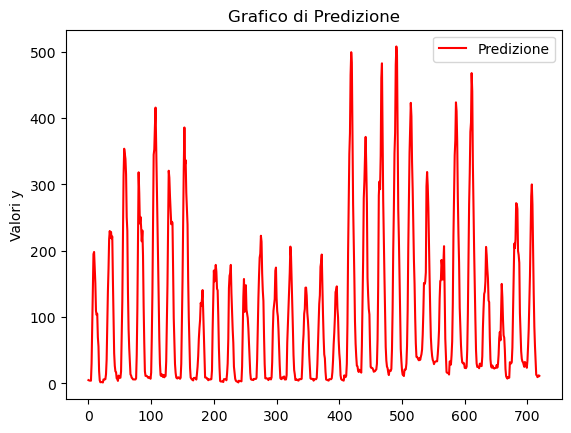

In [217]:
plt.plot(range(len(y_pred_A)), y_pred_A, label='Predizione', color='red', linestyle='-')

# Aggiungi una legenda
plt.legend()

# Aggiungi etichette agli assi
plt.ylabel('Valori y')

# Titolo del grafico
plt.title('Grafico di Predizione')

# Mostra il grafico
plt.show()

In [218]:
df = pd.DataFrame({'Prediction':y_pred_A})

In [219]:
threshold = 0.05
df['Prediction'] = df['Prediction'].apply(lambda x: 0 if x < threshold else x)

In [220]:
df.to_csv('B.csv')

In [221]:
df.head(50)


,Prediction
0,5.065644
1,4.570654
2,4.323566
3,4.323566
4,4.150902
5,30.268008
6,86.555623
7,137.526254
8,194.950658
9,198.177523
